# Demo of SF error analysis
### Semi-empirical approach to computing second-order statistics of gapped series

Statistical moments of increments. 
$$D_p(\tau)=\langle | x(t+\tau)-x(t))^p | \rangle$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ts_dashboard_utils as ts
import utils as utils  # copied directly from Reynolds project, normalize() added
import sf_funcs as sf

plt.rcParams.update({"font.size": 10})

## Load in the data
A magnetic field time series from PSP

In [2]:
df_raw_full = pd.read_pickle("data/processed/psp/psp_fld_l2_mag_rtn_201811.pkl")
df_raw = df_raw_full["B_R"]
df_raw.head()

Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64

Optionally, check the data for missing data and its frequency, get summary stats

In [3]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}".format(np.std(x)))

### 0PTIONAL CODE END ###

510 missing points
Length of interval: 7522952
Duration of interval: 0 days 17:59:59.987519872
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = nan
Standard deviation = nan


## Standardise each interval to contain 8 correlation times

In [4]:
# Original freq is 0.007s. Resampling to less rapid but still sufficiently high cadence, then splitting into chunks with ~15 correlation times

tce_approx = 500  # s
tce_approx_n = 15
cadence_approx = 0.1  # s

tce_n = 8  # Number of correlation times we want...
interval_length = 4000  # ...across this many points
good_inputs_list = []

df = df_raw.resample(str(cadence_approx) + "S").mean()
interval_length_approx = int(tce_approx * tce_approx_n / cadence_approx)

# We have approximately 10 correlation times in 10,000 points. Let's now be more precise, and calculate the correlation time from each chunk

# Split df into subsets
interval_list_approx = [
    df[i : i + interval_length_approx]
    for i in range(0, len(df) - interval_length_approx + 1, int(interval_length_approx))
]

del df  # free up memory

for interval_approx in interval_list_approx:
    time_lags_lr, r_vec_lr = utils.compute_nd_acf(
        [interval_approx],
        nlags=10000,
        plot=False,
    )

    tce = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

    if tce == -1:
        tce = 500
        new_cadence = tce_n * tce / interval_length
        print(
            f"tce not found for this chunk, setting to 500s (default) -> cadence = {new_cadence}s"
        )

    else:
        new_cadence = tce_n * tce / interval_length
        print(
            f"tce calculated to be {np.round(tce,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tce_n}tce across {interval_length} points)"
        )

    interval_approx_resampled = interval_approx.resample(
        str(new_cadence) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        int_norm = utils.normalize(interval)
        good_inputs_list.append(int_norm)

print(
    "\nNumber of standardised intervals: "
    + str(len(good_inputs_list))
    + "\n(may be more than one per original chunk for small cadences)"
)

tce calculated to be 472.44s -> cadence = 0.94s (for 8tce across 4000 points)
tce calculated to be 519.81s -> cadence = 1.04s (for 8tce across 4000 points)
tce calculated to be 724.28s -> cadence = 1.45s (for 8tce across 4000 points)
tce calculated to be 612.58s -> cadence = 1.23s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s
tce calculated to be 181.96s -> cadence = 0.36s (for 8tce across 4000 points)
tce calculated to be 860.62s -> cadence = 1.72s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s

Number of standardised intervals: 12
(may be more than one per original chunk for small cadences)


[[<matplotlib.lines.Line2D at 0x22e224d3730>],

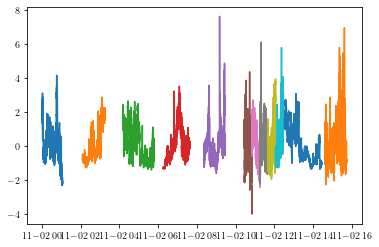

In [5]:
[plt.plot(interval) for interval in good_inputs_list]

In [6]:
len(good_inputs_list)

12

## Remove data from each input multiple times and compute SF, naive and interpolated

In [7]:
# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(good_inputs_list[0]))
# lags = np.unique(vals.astype(int))
lags = np.arange(1, 0.25 * len(good_inputs_list[0]))
powers = [2]
times_to_gap = 3

good_outputs_list = []
all_bad_inputs_list = []
all_bad_outputs_list = []
all_interp_inputs_list = []
all_interp_outputs_list = []

for i, input in enumerate(good_inputs_list):
    print("\nProcessing input {}".format(i))
    good_output = sf.compute_sf(pd.DataFrame(input), lags, powers)
    good_outputs_list.append(good_output)

    bad_inputs_list = []
    bad_outputs_list = []
    interp_inputs_list = []
    interp_outputs_list = []

    for total_removal in np.random.uniform(0, 0.9, times_to_gap):
        # Remove data (up to about 90%, may be some numerical issues with large %)
        # in both chunks and uniformly - split given by ratio_removal
        ratio_removal = np.random.uniform()
        print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_temp, bad_input_ind, prop_removed = ts.remove_data(
            input, prop_remove_chunks, chunks=5
        )
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_temp, prop_remove_unif
        )

        print(
            "Removed {0:.1f}% (approx. {1:.1f}% in chunks, {2:.1f}% uniformly)".format(
                prop_removed * 100, prop_remove_chunks * 100, prop_remove_unif * 100
            )
        )

        bad_inputs_list.append(bad_input)

        # Linearly interpolate the missing data
        interp_input = bad_input.interpolate(method="linear")
        interp_inputs_list.append(interp_input)

        bad_output = sf.compute_sf(pd.DataFrame(bad_input), lags, powers)
        bad_output["error"] = bad_output["sosf"] - good_output["sosf"]
        bad_output["error_percent"] = bad_output["error"] / good_output["sosf"] * 100
        bad_output["missing_prop_overall"] = prop_removed
        bad_output["lint"] = False
        bad_outputs_list.append(bad_output)

        interp_output = sf.compute_sf(pd.DataFrame(interp_input), lags, powers)
        interp_output["error"] = interp_output["sosf"] - good_output["sosf"]
        interp_output["error_percent"] = (
            interp_output["error"] / good_output["sosf"] * 100
        )
        interp_output["missing_prop_overall"] = prop_removed
        interp_output["missing_prop"] = bad_output["missing_prop"]
        interp_output["missing_prop"] = bad_output["missing_prop"]
        interp_output["sosf_se"] = bad_output["sosf_se"]
        # NOTE: Seems sensible uncertainty is the same for both
        interp_output["lint"] = True
        interp_outputs_list.append(interp_output)

    all_bad_inputs_list.append(bad_inputs_list)
    all_bad_outputs_list.append(bad_outputs_list)
    all_interp_inputs_list.append(interp_inputs_list)
    all_interp_outputs_list.append(interp_outputs_list)


Processing input 0
Nominal total removal: 4.4%
Nominal ratio: 34.1%
Removed 4.5% (approx. 1.5% in chunks, 2.9% uniformly)
Nominal total removal: 53.8%
Nominal ratio: 31.6%
Removed 49.2% (approx. 17.0% in chunks, 36.8% uniformly)
Nominal total removal: 25.1%
Nominal ratio: 99.2%
Removed 29.4% (approx. 24.9% in chunks, 0.2% uniformly)

Processing input 1
Nominal total removal: 85.9%
Nominal ratio: 12.6%
Removed 77.7% (approx. 10.8% in chunks, 75.1% uniformly)
Nominal total removal: 59.6%
Nominal ratio: 98.3%
Removed 60.6% (approx. 58.6% in chunks, 1.0% uniformly)
Nominal total removal: 33.2%
Nominal ratio: 47.1%
Removed 31.8% (approx. 15.6% in chunks, 17.6% uniformly)

Processing input 2
Nominal total removal: 46.1%
Nominal ratio: 54.1%
Removed 45.1% (approx. 25.0% in chunks, 21.2% uniformly)
Nominal total removal: 60.8%
Nominal ratio: 54.8%
Removed 57.3% (approx. 33.4% in chunks, 27.5% uniformly)
Nominal total removal: 29.8%
Nominal ratio: 61.9%
Removed 28.4% (approx. 18.4% in chunks, 

 Crashed on the following attempt:
` Nominal total removal: 2.5%
Nominal ratio: 1.1%`

## UP TO HERE ON RĀPOI

---

## Check a sample of results, for a given source interval

### Naive

In [2]:
# Read in pickle file data/processed/list_of_list_of_dfs.pkl
import pickle

with open("data/processed/list_of_list_of_dfs.pkl", "rb") as f:
    list_of_list_of_dfs = pickle.load(f)

# Unpack the list of list of dfs
(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
) = list_of_list_of_dfs


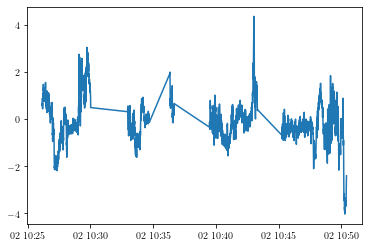

In [3]:
plt.plot(all_interp_inputs_list[5][0])

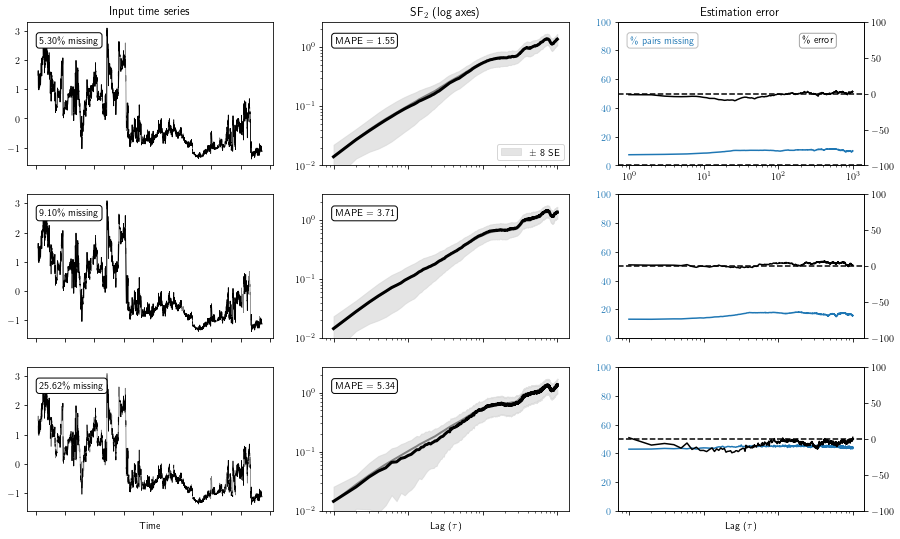

In [4]:
# Check results, for a given clean input

input_ind = 10
n = 3

sf.plot_sample(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    "C0",
    input_ind,
    3,
    False,
)

### Interpolated
NB: Error region for these results are taken from the SE for the naive calculations, relecting the increased uncertainty of fewer *true* observations

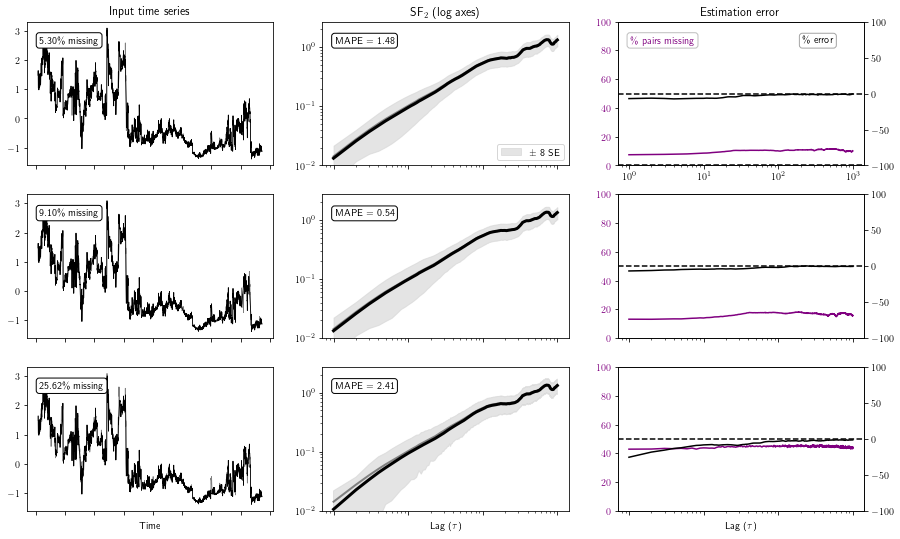

In [5]:
sf.plot_sample(
    good_inputs_list,
    good_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
    "purple",
    input_ind,
    3,
    False,
)

## Do holistic analysis of errors

In [6]:
# Concatenate the list of lists of dataframes to a single dataframe for error analysis

bad_outputs_df = pd.concat([pd.concat(lst) for lst in all_bad_outputs_list])
interp_outputs_df = pd.concat([pd.concat(lst) for lst in all_interp_outputs_list])

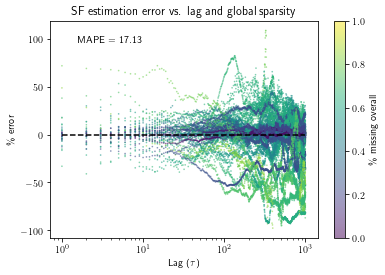

In [7]:
# View trends as fn of OVERALL missing amount
sf.plot_error_trend_line(bad_outputs_df)

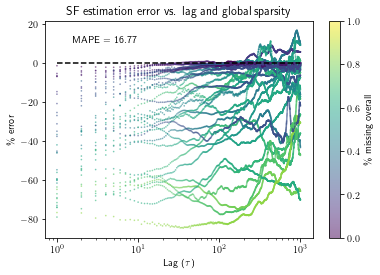

In [8]:
sf.plot_error_trend_line(interp_outputs_df)

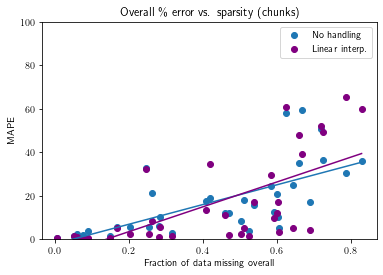

In [9]:
sf.plot_error_trend_scatter(bad_outputs_df, interp_outputs_df)

## Create empirical correction factor

Here we work with the interpolated output errors, as they are more consistent that the no-handling errors (as evident in the error vs. lag and global sparsity plot), and with the *local* sparsity, as this gives us more information than the global sparsity.

In [10]:
sparsity_type = "missing_prop"
num_bins = 12


In [11]:
# Attempted logarithmic heatmap binning with the following, but couldn't get to work

# x_bins = np.logspace(0, 3, 25) - 1
# y_bins = np.logspace(0, 2, 25) / 100 - 0.01
# y_bins[-1] = 1
# x_bins[-1] = 1000

# heatmap, xedges, yedges = np.histogram2d(
#     x, y, bins=[x_bins, y_bins], range=[[0, 1000], [0, 1]]
# )



In [12]:
heatmap_bin_vals, heatmap_bin_edges, lookup_table = sf.create_heatmap_lookup(
    interp_outputs_df, sparsity_type, num_bins
)


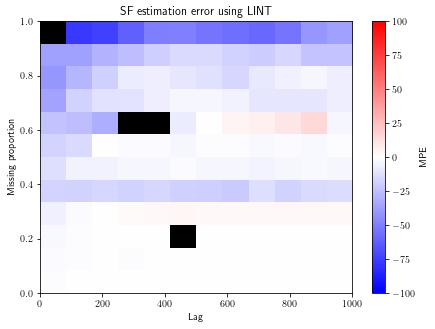

In [13]:
axs = sf.plot_heatmap(
    heatmap_bin_vals,
    heatmap_bin_edges,
    "Missing proportion",
    False,
)

Check out sample size in each bin (above just shows where there is no data with black bins)

Text(0.5, 1.0, 'Distribution of missing proportion and lag')

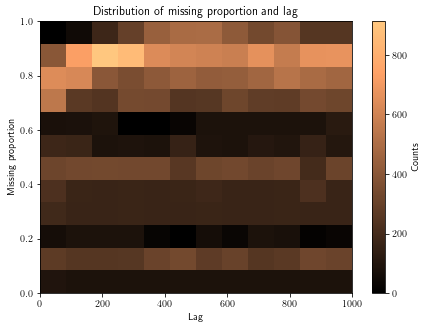

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))
hb = ax.hist2d(
    interp_outputs_df["lag"],
    interp_outputs_df[sparsity_type],
    bins=num_bins,
    cmap="copper",
    range=[[0, 1000], [0, 1]],
)
plt.colorbar(hb[3], ax=ax, label="Counts")
plt.xlabel("Lag")
plt.ylabel("Missing proportion")
plt.title("Distribution of missing proportion and lag")

## Apply empirical correction factor to bad SFs


Correcting interval 0:
No nearest row found for lag 375.0! Scaling set to 1
No nearest row found for lag 376.0! Scaling set to 1
No nearest row found for lag 377.0! Scaling set to 1
No nearest row found for lag 378.0! Scaling set to 1
No nearest row found for lag 379.0! Scaling set to 1
No nearest row found for lag 380.0! Scaling set to 1
No nearest row found for lag 381.0! Scaling set to 1
No nearest row found for lag 382.0! Scaling set to 1
No nearest row found for lag 383.0! Scaling set to 1
No nearest row found for lag 384.0! Scaling set to 1
No nearest row found for lag 385.0! Scaling set to 1
No nearest row found for lag 386.0! Scaling set to 1
No nearest row found for lag 387.0! Scaling set to 1
No nearest row found for lag 388.0! Scaling set to 1
No nearest row found for lag 389.0! Scaling set to 1
No nearest row found for lag 390.0! Scaling set to 1
No nearest row found for lag 391.0! Scaling set to 1
No nearest row found for lag 392.0! Scaling set to 1
No nearest row found f

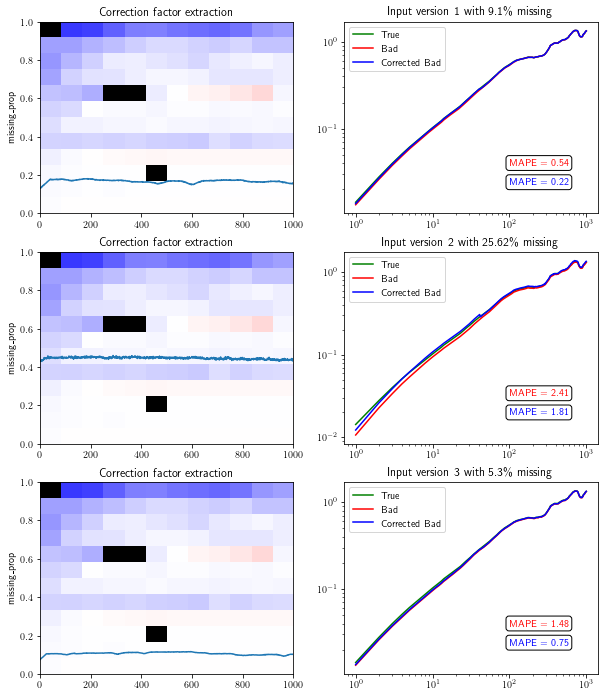

In [15]:
# Compute scaling factors for a given corrupted interval
# (ensure using interp factors for interp interval)
intervals = [0, 1, 2]  # Specify the intervals to plot

fig, axs = plt.subplots(
    len(intervals), 2, figsize=(10, 4 * len(intervals))
)  # Create a 3x1 plot

for i, interval in enumerate(intervals):
    print(f"\nCorrecting interval {interval}:")
    sf_corrected = sf.compute_scaling(
        all_interp_outputs_list[input_ind][interval],
        sparsity_type,
        lookup_table,
    )
    sf_corrected["error_corrected"] = (
        sf_corrected["sosf_corrected"] - good_outputs_list[input_ind]["sosf"]
    )
    sf_corrected["error_percent_corrected"] = (
        sf_corrected["error_corrected"] / good_outputs_list[input_ind]["sosf"] * 100
    )
    mape_bad = sf_corrected["error_percent"].abs().mean()
    mape_corrected = sf_corrected["error_percent_corrected"].abs().mean()

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_bad),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.65, 0.25),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="red",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.65, 0.15),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="blue",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    axs[i, 1].plot(good_outputs_list[input_ind]["sosf"], c="green", label="True")
    axs[i, 1].plot(
        all_interp_outputs_list[input_ind][interval]["sosf"], c="red", label="Bad"
    )
    # axs[i, 1].plot(
    #     sf_corrected["sosf"] * sf_corrected["scaling"], c="blue", label="Corrected Bad"
    # )
    axs[i, 1].plot(sf_corrected["sosf_corrected"], c="blue", label="Corrected Bad")
    axs[i, 1].semilogx()
    axs[i, 1].semilogy()
    axs[i, 1].legend()
    axs[i, 1].set_title(
        f"Input version {interval+1} with {np.round(sf_corrected['missing_prop_overall'].values[0]*100, 2)}\% missing"
    )

    axs[i, 0] = sf.plot_heatmap(
        heatmap_bin_vals,
        heatmap_bin_edges,
        missing_measure=sparsity_type,
        log=False,
        overlay_x=all_interp_outputs_list[input_ind][interval]["lag"],
        overlay_y=all_interp_outputs_list[input_ind][interval][sparsity_type],
        subplot=axs[i, 0],
    )

## Trialling 3D heatmap

In [16]:
# Compute heatmap of average error as fn of lag and missing prop at that lag
heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(
        interp_outputs_df,
        sparsity_type,
        10,
    )
)

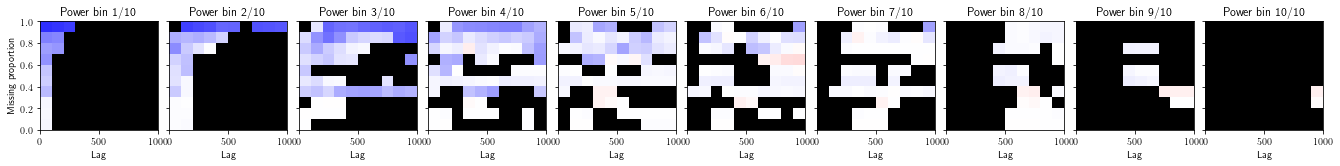

In [17]:
fig, axs = plt.subplots(1, 10, figsize=(23, 2))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.1)
n_bins_power = len(heatmap_bin_edges_3d[2]) - 1
for i in range(n_bins_power):
    axs[i] = sf.plot_heatmap(
        heatmap_bin_vals_3d[:, :, i],
        heatmap_bin_edges_3d[:2],
        "Missing proportion",
        False,
        subplot=axs[i],
        # title=f"Hmap for power bin {i+1}/{n_bins_power}".format(
        #     np.round(heatmap_bin_edges[2][i], 2)
        # ),
    )
    axs[i].set_title(
        f"Power bin {i+1}/{n_bins_power}".format(
            np.round(heatmap_bin_edges_3d[2][i], 2)
        )
    )
    axs[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        axs[i].set_yticklabels([])
        axs[i].set_ylabel("")


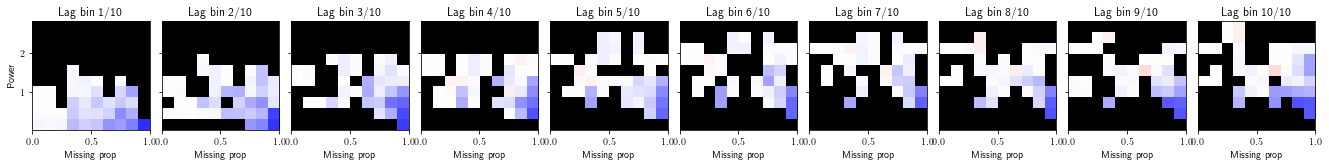

In [18]:
fig, axs = plt.subplots(1, 10, figsize=(23, 2))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.1)
n_bins_power = len(heatmap_bin_edges_3d[2]) - 1
for i in range(n_bins_power):
    axs[i] = sf.plot_heatmap(
        heatmap_bin_vals_3d[i, :, :],
        heatmap_bin_edges_3d[1:],
        "Missing proportion",
        False,
        subplot=axs[i],
        # title=f"Hmap for power bin {i+1}/{n_bins_power}".format(
        #     np.round(heatmap_bin_edges[2][i], 2)
        # ),
    )
    axs[i].set_title(
        f"Lag bin {i+1}/{n_bins_power}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    axs[i].set_xlabel("Missing prop")
    axs[i].set_ylabel("Power")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        axs[i].set_yticklabels([])
        axs[i].set_ylabel("")


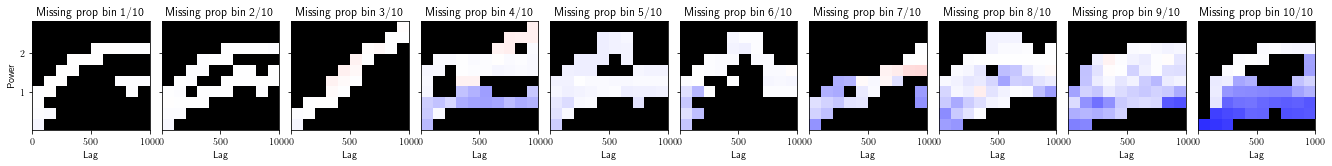

In [19]:
fig, axs = plt.subplots(1, 10, figsize=(23, 2))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.1)
n_bins_power = len(heatmap_bin_edges_3d[1]) - 1
for i in range(n_bins_power):
    axs[i] = sf.plot_heatmap(
        heatmap_bin_vals_3d[:, i, :],
        [heatmap_bin_edges_3d[0], heatmap_bin_edges_3d[2]],
        "Missing proportion",
        False,
        subplot=axs[i],
        # title=f"Hmap for power bin {i+1}/{n_bins_power}".format(
        #     np.round(heatmap_bin_edges[2][i], 2)
        # ),
    )
    axs[i].set_title(
        f"Missing prop bin {i+1}/{n_bins_power}".format(
            np.round(heatmap_bin_edges_3d[1][i], 2)
        )
    )
    axs[i].set_xlabel("Lag")
    axs[i].set_ylabel("Power")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        axs[i].set_yticklabels([])
        axs[i].set_ylabel("")



Correcting interval 0:
More than one nearest row found!
More than one nearest row found!
More than one nearest row found!
More than one nearest row found!
More than one nearest row found!
No nearest row found for lag 551.0! Scaling set to 1
No nearest row found for lag 552.0! Scaling set to 1
No nearest row found for lag 553.0! Scaling set to 1
No nearest row found for lag 554.0! Scaling set to 1
No nearest row found for lag 555.0! Scaling set to 1
No nearest row found for lag 556.0! Scaling set to 1
No nearest row found for lag 557.0! Scaling set to 1
No nearest row found for lag 558.0! Scaling set to 1
No nearest row found for lag 559.0! Scaling set to 1
No nearest row found for lag 560.0! Scaling set to 1
No nearest row found for lag 561.0! Scaling set to 1
No nearest row found for lag 562.0! Scaling set to 1
No nearest row found for lag 563.0! Scaling set to 1
No nearest row found for lag 564.0! Scaling set to 1
No nearest row found for lag 565.0! Scaling set to 1
No nearest row f

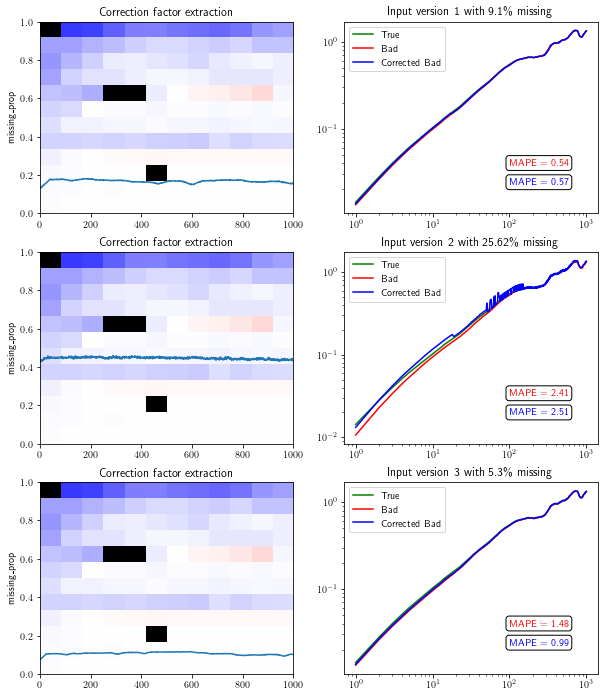

In [20]:
# Compute scaling factors for a given corrupted interval
# (ensure using interp factors for interp interval)

fig, axs = plt.subplots(
    len(intervals), 2, figsize=(10, 4 * len(intervals))
)  # Create a 3x1 plot

for i, interval in enumerate(intervals):
    print(f"\nCorrecting interval {interval}:")
    sf_corrected = sf.compute_scaling_3d(
        all_interp_outputs_list[input_ind][interval],
        sparsity_type,
        lookup_table_3d,
    )
    sf_corrected["error_corrected"] = (
        sf_corrected["sosf_corrected"] - good_outputs_list[input_ind]["sosf"]
    )
    sf_corrected["error_percent_corrected"] = (
        sf_corrected["error_corrected"] / good_outputs_list[input_ind]["sosf"] * 100
    )
    mape_bad = sf_corrected["error_percent"].abs().mean()
    mape_corrected = sf_corrected["error_percent_corrected"].abs().mean()

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_bad),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.65, 0.25),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="red",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.65, 0.15),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="blue",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    axs[i, 1].plot(good_outputs_list[input_ind]["sosf"], c="green", label="True")
    axs[i, 1].plot(
        all_interp_outputs_list[input_ind][interval]["sosf"], c="red", label="Bad"
    )
    # axs[i, 1].plot(
    #     sf_corrected["sosf"] * sf_corrected["scaling"], c="blue", label="Corrected Bad"
    # )
    axs[i, 1].plot(sf_corrected["sosf_corrected"], c="blue", label="Corrected Bad")
    axs[i, 1].semilogx()
    axs[i, 1].semilogy()
    axs[i, 1].legend()
    axs[i, 1].set_title(
        f"Input version {interval+1} with {np.round(sf_corrected['missing_prop_overall'].values[0]*100, 2)}\% missing"
    )

    axs[i, 0] = sf.plot_heatmap(
        heatmap_bin_vals,
        heatmap_bin_edges,
        missing_measure=sparsity_type,
        log=False,
        overlay_x=all_interp_outputs_list[input_ind][interval]["lag"],
        overlay_y=all_interp_outputs_list[input_ind][interval][sparsity_type],
        subplot=axs[i, 0],
    )
